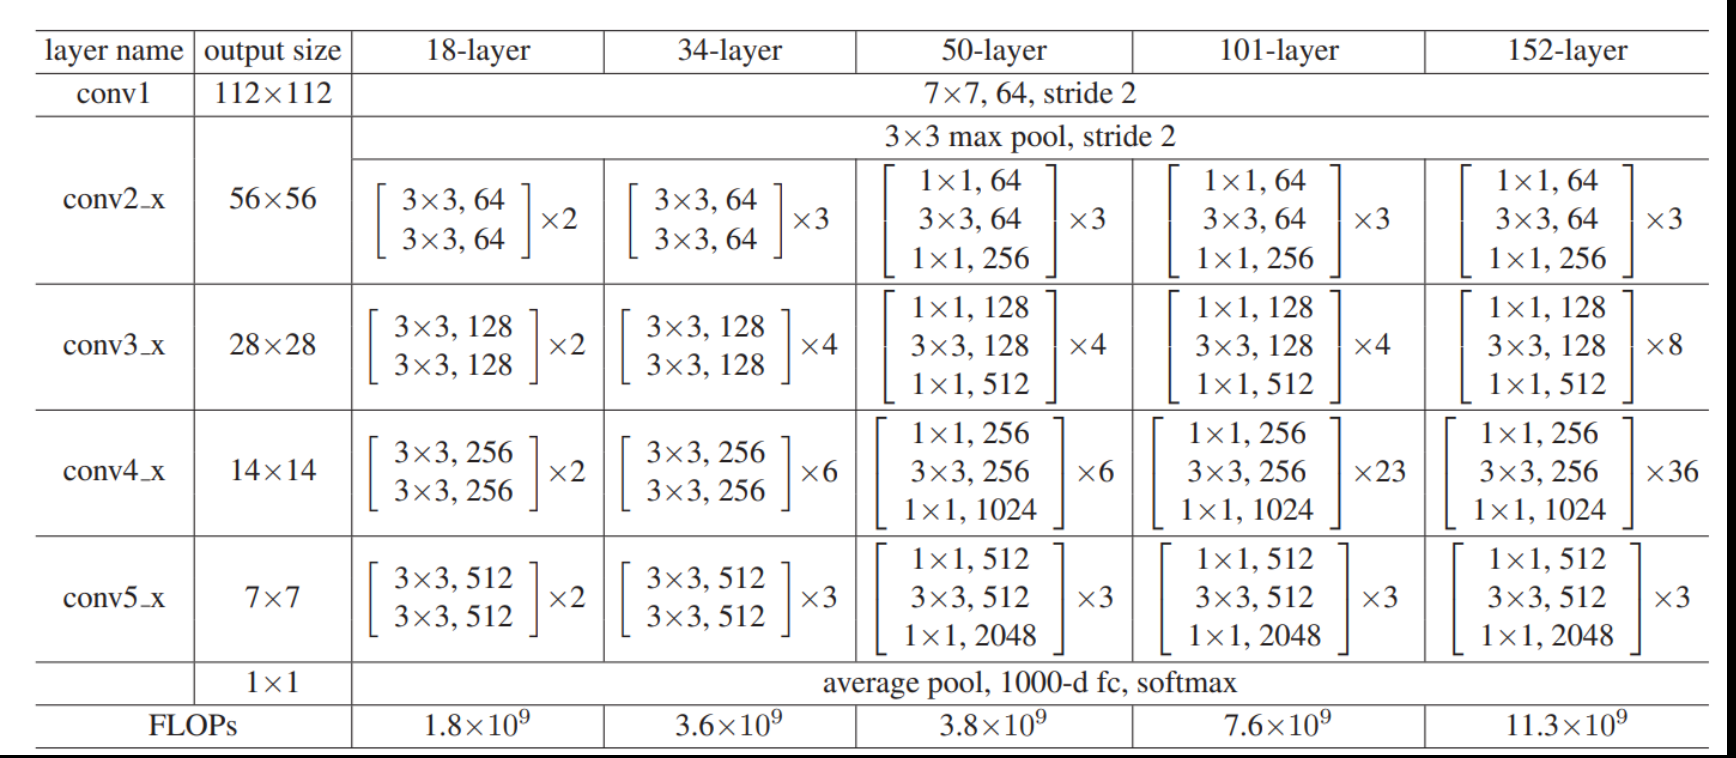

Implementation of Resnet

Resnet : Going deeper with convolutions <br>
https://arxiv.org/pdf/1409.4842.pdf

In [127]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from torchsummary import summary

In [128]:
def custom_imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [129]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


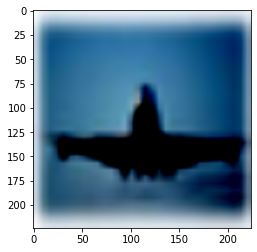

plane


In [130]:
sample_num = 694

custom_imshow(trainset[sample_num][0])
print(classes[trainset[sample_num][1]])

In [131]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

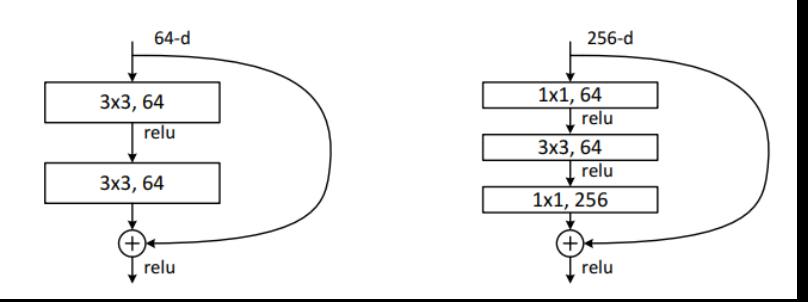

In [132]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, downsample = None, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out
    
class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, in_channels, out_channels, downsample = None, stride = 1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride = stride)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)

        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

In [133]:
class Resnet(torch.nn.Module):
    def __init__(self, block = BasicBlock, layers = [2, 2, 2, 2], in_channels=3, num_classes=10):
        super(Resnet, self).__init__()
        
        self.inplanes = 64
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, self.inplanes, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.conv2_x = self._make_layer(block, layers[0], 64)
        self.conv3_x = self._make_layer(block, layers[1], 128, 2)
        self.conv4_x = self._make_layer(block, layers[2], 256, 2)
        self.conv5_x = self._make_layer(block, layers[3], 512, 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block = BasicBlock, blocks = 2, in_channels = 3, stride = 1):
        
        downsample = None
        
        if stride != 1 or self.inplanes != in_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, in_channels * block.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(in_channels * block.expansion),
            )
        
        layers = []
        layers.append(
            block(self.inplanes, in_channels, downsample, stride)
        )
        
        self.inplanes = in_channels * block.expansion
        
        for _ in range(1, blocks):
            layers.append(
                block(self.inplanes, in_channels)
            )
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x
        

In [134]:
model = Resnet(Bottleneck, [3, 4, 6, 3], 3, 10).cuda()
summary(model, input_size=(3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,640
      BatchNorm2d-14          [-1, 256,

In [135]:
lr = 1e-5
epochs = 100

In [136]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [139]:
for epoch in range(epochs):
    print("\nEpoch ", epoch)
    # train
    print("\nTrain:")
    model.train()
    train_loss = 0
    for i, (images, targets) in enumerate(train_loader): 
        images, targets = images.to(device), targets.to(device)
        
        pred = model(images)
        loss = F.cross_entropy(pred, targets)    

        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ((i+1) % (len(train_loader) // 30) == 1) or i+1 == len(train_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(train_loader), train_loss/(i+1)))
    # val
    print("\nValidation")
    model.eval()
    val_loss = 0
    correct = 0
    for i, (images, targets) in enumerate(test_loader):
        images, targets = images.to(device), targets.to(device)
        
        out = model(images)
        loss = F.cross_entropy(out, targets)    
        
        val_loss += loss.item()

        pred = torch.argmax(out, 1)
        
        correct += (pred==targets).sum().item()
        
        
        
        if ((i+1) % (len(test_loader) // 3) == 1) or i+1 == len(test_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(test_loader), val_loss/(i+1)))
    print(f"Accuracy of the network : {100*correct//(len(test_loader)*batch_size)}%")


Epoch  0

Train:
[  1/782] | Loss: 2.42961
[ 27/782] | Loss: 2.28729
[ 53/782] | Loss: 2.25390
[ 79/782] | Loss: 2.21860
[105/782] | Loss: 2.19629
[131/782] | Loss: 2.16534
[157/782] | Loss: 2.13463
[183/782] | Loss: 2.11216
[209/782] | Loss: 2.08740
[235/782] | Loss: 2.06504
[261/782] | Loss: 2.04464
[287/782] | Loss: 2.02611
[313/782] | Loss: 2.00819
[339/782] | Loss: 1.99184
[365/782] | Loss: 1.97858
[391/782] | Loss: 1.96457
[417/782] | Loss: 1.94970
[443/782] | Loss: 1.93687
[469/782] | Loss: 1.92465
[495/782] | Loss: 1.91340
[521/782] | Loss: 1.90388
[547/782] | Loss: 1.89184
[573/782] | Loss: 1.88231
[599/782] | Loss: 1.87120
[625/782] | Loss: 1.86000
[651/782] | Loss: 1.85023
[677/782] | Loss: 1.83992
[703/782] | Loss: 1.83032
[729/782] | Loss: 1.82047
[755/782] | Loss: 1.81107
[781/782] | Loss: 1.80227
[782/782] | Loss: 1.80216

Validation
[  1/157] | Loss: 1.56931
[ 53/157] | Loss: 1.54217
[105/157] | Loss: 1.53213
[157/157] | Loss: 1.53794
Accuracy of the network : 43%

Epo

KeyboardInterrupt: 